### create data from stock

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [70]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from curl_cffi import requests
from sklearn.externals import joblib

SYMBOL = "IFX.DE"
HISTORY = "10y"

class Stock_Model:
    CLASSES = ["Bull", "Bear"]
    def __init__(self, stock, period, interval="1d", win_size=60):
        self._stock = stock
        self._period = period
        self._interval = interval
        self._window_size = win_size # default 60 days
        self._model_name = f"{self._stock}_{self._period}_{self._interval}_{self._window_size}"
        ### default all features
        self._base_features = np.array([['Open', 'High', 'Low', 'Close', 'Volume', "Dividends", "Stock Splits"]])
        self._stock_data = None
        self._X_train = None
        self._Y_train = None
        self._X_test = None
        self._Y_test = None
        self._data = None
        self._model = None

    @property
    def model_name(self):
        return self._model_name
        
    @property
    def stock_data(self):
        return self._stock_data

    @property
    def test_data(self):
        if self._data is None:
            return None
        return self._data

    @property
    def test_data_num(self):
        if self._data is None:
            return 0
        return len(self._data)
        
    @property
    def features(self):
        if self._features is None:
            return self._base_features
        return self._features

    @property
    def window_size(self):
        return self._window_size

    @window_size.setter
    def window_size(self, ws):
        self._window_size = ws
        
    def load_stock(self, stock=None, period=None, interval=None):
        ## read stock data from stock markt
        self._stock = stock if stock is not None else self._stock
        self._period = period if period is not None else self._period
        self._interval = interval if interval is not None else self._interval    
        self.session = requests.Session(impersonate="chrome")
        self._stock_data = yf.Ticker(self._stock, session=self.session).history(period=self._period, interval=self._interval)
        self._features = None
        # self._data = self._stock_data ## used for prediction process
        
    def set_working_data(self, start_feature=0, end_feature=5, remove_cols=["Dividends", "Stock Splits"]):
        self._features = []
        self._features = np.array([self._base_features[0, start_feature:end_feature]])
        ### remove meaningless columns
        self._data = self._stock_data.drop(columns=remove_cols)
        # remove today data
        self._data = self._data[:-1]
        self._normalize_data()
    
    def _normalize_data(self):
        self._scaler = MinMaxScaler(feature_range=(0, 1))
        self._data = self._scaler.fit_transform(self._data)

    def _create_sequences(self):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        X, Y = [], []
        for i in range(self.test_data_num - self._window_size):
            # Input: add all features: Open, High, Low, Close, Volume
            X.append(self._data[i:i+self._window_size, :]) 
            # Output: predict Close price
            Y.append(self._data[i+self._window_size, 3]) 
        return np.array(X), np.array(Y)

    def create_train_test_data(self, train_data_percentage=0.7):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        if train_data_percentage >= 1.0:
            raise ValueError("Percent must less than 1.0")
        X, Y = self._create_sequences()
        split = int(train_data_percentage * len(X))
        self._X_train, self._X_test = X[:split], X[split:]
        self._Y_train, self._Y_test = Y[:split], Y[split:]

    def create_LSTM_model(self):
        self._model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(self._X_train.shape[1], self._X_train.shape[2])),  # 输入维度为 (窗口大小, 特征数)
            Dropout(0.3),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])

    def compile_model(self, optim='adam', loss='mse'):
        self._model.compile(optimizer=optim, loss=loss)

    def train_model(self, early_stop=True, monitor='val_loss', patience=10, epochs=100, batch_size=32):
        callback=[]
        if early_stop:
            cb_early_stop = EarlyStopping(monitor=monitor, patience=patience)
            callback.append(cb_early_stop)
        self._history = self._model.fit(
            self._X_train, self._Y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callback,
            verbose=1
        )

    def model_predict(self, data=None):
        if self._model is None:
            print("Warning: model is None. It must be created or loaded!")
            return
        if data:
            self._data = data
            self._normalize_data()
            self._Y_predict = self._model.predict(data)
        else:
            self._Y_predict = self._model.predict(self._X_test)
            self.invert_normalized_data()
            # 真实值反归一化
            dummy_matrix[:, 3] = self._Y_test
            self._Y_test_actual = self._scaler.inverse_transform(dummy_matrix)[:, 3]

    def invert_normalized_data(self):
        # 反归一化需要重建完整的多变量矩阵（仅Close列有值，其他列置0）
        dummy_matrix = np.zeros((len(y_pred), self.features.shape[1]))
        dummy_matrix[:, 3] = self._Y_predict.flatten()  # 第4列是Close
        self._Y_pred_actual = self._scaler.inverse_transform(dummy_matrix)[:, 3]

    def visual_result(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self._Y_test_actual, label='True Close Price')
        plt.plot(self._Y_pred_actual, label='Predicted Close Price', alpha=0.7)
        plt.title('Multivariate LSTM Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def save_model(self):
        joblib.dump(self._model, f"{self._model_name}.m")

    def load_model(self):
        self._model = joblib.load(self._model_name)

In [71]:
stock_daten = stock_datasets(SYMBOL, HISTORY)
stock_daten.load_stock()
stock_daten.features.shape

(1, 7)

<Figure size 800x500 with 0 Axes>

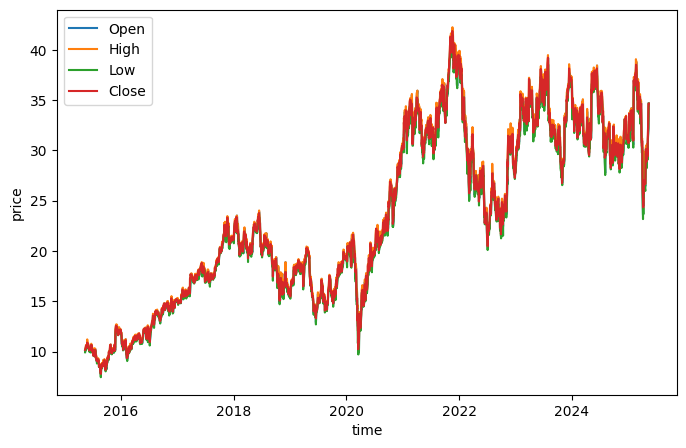

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(8, 5))
plt.plot(stock_daten.stock_data[stock_daten.features[0]], label=stock_daten.features[0])
plt.plot(stock_daten.stock_data[stock_daten.features[1]], label=stock_daten.features[1])
plt.plot(stock_daten.stock_data[stock_daten.features[2]], label=stock_daten.features[2])
plt.plot(stock_daten.stock_data[stock_daten.features[3]], label=stock_daten.features[3])
#plt.xlim('2023.01.01', '2023.12.31')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [72]:
stock_daten.set_working_data()
print(stock_daten.test_data)
print(stock_daten.test_data.shape)
print(stock_daten.features.shape)

[[0.06437532 0.06564158 0.07292039 0.06971917 0.094798  ]
 [0.0705001  0.06955036 0.07910228 0.0708995  0.1182765 ]
 [0.07193359 0.07085332 0.07778702 0.07562092 0.08766944]
 ...
 [0.68778592 0.69703612 0.69650643 0.69434059 0.09870626]
 [0.71167368 0.76781359 0.72796785 0.7698346  0.19533636]
 [0.77343214 0.77888171 0.77721811 0.78830501 0.1133851 ]]
(2542, 5)
(1, 5)


### check loaded data

#### construct datasets

In [73]:
stock_daten.create_train_test_data()

In [74]:
print(stock_daten._X_train.shape, stock_daten._Y_train.shape)
print(stock_daten._Y_train)
print(stock_daten._X_test.shape, stock_daten._Y_test.shape)

(1737, 60, 5) (1737,)
[0.03666943 0.03968585 0.03058407 ... 0.58839529 0.58426416 0.55648589]
(745, 60, 5) (745,)


In [75]:
stock_daten.create_LSTM_model()

C:\Users\Peilian.Yuan.SYKAM\AppData\Local\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
stock_daten.compile_model()

In [77]:
stock_daten.train_model()

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0165
Epoch 2/100
 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053

C:\Users\Peilian.Yuan.SYKAM\AppData\Local\anaconda3\envs\tf\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018    
Epoch 13/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 14/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020
Epoch 15/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019
Epoch 16/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

In [78]:
y_pred = stock_daten._model.predict(stock_daten._X_test)
# 反归一化需要重建完整的多变量矩阵（仅Close列有值，其他列置0）
dummy_matrix = np.zeros((len(y_pred), stock_daten.features.shape[1]))
dummy_matrix[:, 3] = y_pred.flatten()  # 第4列是Close
y_pred_actual = scaler.inverse_transform(dummy_matrix)[:, 3]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 


NameError: name 'scaler' is not defined